# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time

# Importing the data set

In [2]:
try:
    taxi_df = pd.read_csv("./taxi_duration_train.csv", )
except:
    print("Could not locate the relevant CSV file!")

In [3]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# Building a Pipeline to transform the data set

At this point, I attempt to build a pipeline to help pipe the necessary transformations that we would need to take, based on a given data's structure, and the additional features (if any) that we would want to create for a "vanilla" data set.

## Importing the Pipeline library from scikit-learn

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

## A Class to engineer the necessary date and time features

In [5]:
class EngineerDateTimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def _create_date_time_cols(self, df):
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
        df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
        
        # Getting a Day of the Week for the pickup
        df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek + 1

        # Getting the day's date of the pickup
        df['pickup_day_date'] = df['pickup_datetime'].dt.day

        # Getting the month of the pickup
        df['pickup_mth'] = df['pickup_datetime'].dt.month

        # Getting the year of the pickup
        df['pickup_yr'] = df['pickup_datetime'].dt.year

        # Getting the hour of the pickup
        df['pickup_time_hour'] = df['pickup_datetime'].dt.hour
        
        # Getting the minute of the pickup
        df['pickup_time_min'] = df['pickup_datetime'].dt.minute

        # Getting the hour of the dropoff
        df['dropoff_time_hour'] = df['dropoff_datetime'].dt.hour
        
        # Getting the minute of the dropoff
        df['dropoff_time_min'] = df['dropoff_datetime'].dt.minute
        
        return df
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        _temp_df = self._create_date_time_cols(X.copy())
        return _temp_df

## A Class to engineer the necessary Euclidean distance based on the latitude and longitude of the pickups and dropoffs

In [6]:
class EngineerDistanceFeature(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    # Credits to: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
    def _haversine_np(self, lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees)

        All args must be of equal length.    

        """
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km
    
    def _create_euc_dist_cols(self, df):
        df['trip_euc_dist'] = self._haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])
        return df
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        _temp_df = self._create_euc_dist_cols(X.copy())
        return _temp_df

## A Class to conduct feature selection and remove the unnecessary columns

In [7]:
class SelectFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def _drop_my_cols(self, df):
        _temp_df = df.drop(columns=['id', 'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime', 'pickup_yr'])
        return _temp_df
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        _temp_df = self._drop_my_cols(X.copy())
        return _temp_df

## A Class to maintain the FeatureUnion's numpy array output as a Pandas DataFrame

This class remains unused, but I'll leave it here as potential future reference.

In [8]:
class PandasTransform(BaseEstimator, TransformerMixin):
    def __init__(self, fn):
        self.fn = fn
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None, copy=None):
        return self.fn(X)

## Apply the transformations on the test data set and concatenate the transformations with the pipeline and FeatureUnion

This is where we pipe the different classes that we have created in the above paragraphs, and what a combined pipeline would look like.

In [9]:
preprocess_pipeline = Pipeline([
    ("engineer_date_time_features", EngineerDateTimeFeatures()),
    ("engineer_distance_features", EngineerDistanceFeature()),
    ("select_features", SelectFeatures()),
])

In [10]:
# Keep track of how long the pipelined transformation takes 
start = time.time()

taxi_df_transformed = preprocess_pipeline.fit_transform(taxi_df)

end = time.time()

print("The time taken for the data preprocessing transformation pipeline was " + "{:.2f}".format(end - start) + " seconds.")

The time taken for the data preprocessing transformation pipeline was 2.37 seconds.


In [11]:
taxi_df_transformed.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day_of_week,pickup_day_date,pickup_mth,pickup_time_hour,pickup_time_min,dropoff_time_hour,dropoff_time_min,trip_euc_dist
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,1,14,3,17,24,17,32,1.497580
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,7,12,6,0,43,0,54,1.804374
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,2,19,1,11,35,12,10,6.381090
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,3,6,4,19,32,19,39,1.484566
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,6,26,3,13,30,13,38,1.187842


In [12]:
taxi_df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 15 columns):
vendor_id             1458644 non-null int64
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
trip_duration         1458644 non-null int64
pickup_day_of_week    1458644 non-null int64
pickup_day_date       1458644 non-null int64
pickup_mth            1458644 non-null int64
pickup_time_hour      1458644 non-null int64
pickup_time_min       1458644 non-null int64
dropoff_time_hour     1458644 non-null int64
dropoff_time_min      1458644 non-null int64
trip_euc_dist         1458644 non-null float64
dtypes: float64(5), int64(10)
memory usage: 166.9 MB


# Splitting our data into a train and test set

## Importing the library to split our data set

In [13]:
from sklearn.model_selection import train_test_split

## Split the data into a train and test set

In [14]:
X = taxi_df_transformed.drop(columns=['trip_duration'], axis=1)
y = taxi_df_transformed['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

In [15]:
X_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_day_of_week,pickup_day_date,pickup_mth,pickup_time_hour,pickup_time_min,dropoff_time_hour,dropoff_time_min,trip_euc_dist
1275522,2,1,-73.971985,40.756863,-73.991417,40.749195,7,17,1,11,55,12,8,1.844412
136887,2,1,-73.870949,40.773731,-73.974922,40.762058,7,12,6,12,0,12,22,8.846212
127429,2,2,-73.989471,40.739880,-73.991920,40.723801,7,31,1,0,13,0,28,1.798637
731318,1,1,-73.972160,40.793903,-73.967621,40.802769,3,29,6,19,13,19,16,1.056588
1252105,1,1,-73.956108,40.819054,-73.945374,40.807621,5,22,1,17,18,17,27,1.558570


# Trying out default models

## Gradient Boosted Decision Trees

## Importing the GBDT module

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

## Setting up the default GBDT Regressor model

In [24]:
gbdt_reg = GradientBoostingRegressor()

## Training a default GBDT model with the training data we have

In [25]:
# We'll additionally track the elapsed time taken to train the model
start = time.time()

gbdt_reg.fit(X_train, y_train)

end = time.time()
print("The time taken to train the Gradient Boosting Decision Tree regression model is " + "{:.2f}".format(end - start) + " seconds.")

The time taken to train the Gradient Boosting Decision Tree regression model is 265.49 seconds.


## Predicting the test data set

In [27]:
predicted_results = gbdt_reg.predict(X_test)

## Comparing the predicted values against the actual

In [28]:
compare_df = pd.DataFrame(columns=['actual', 'predicted'])
compare_df['actual'] = y_test
compare_df['predicted'] = predicted_results

In [29]:
compare_df.head()

,actual,predicted
714698,281,667.122052
1369888,590,649.997120
355495,535,493.186827
1383718,522,604.879097
951815,965,1591.902741


## Check out the performance of the default GBDT model by predicting the test data set

In [44]:
mean_squared_error(y_test, gbdt_reg.predict(X_test))

45705996.847256996

## Looking at the feature importance, based on the default GBDT model

Text(0, 0.5, 'Features')

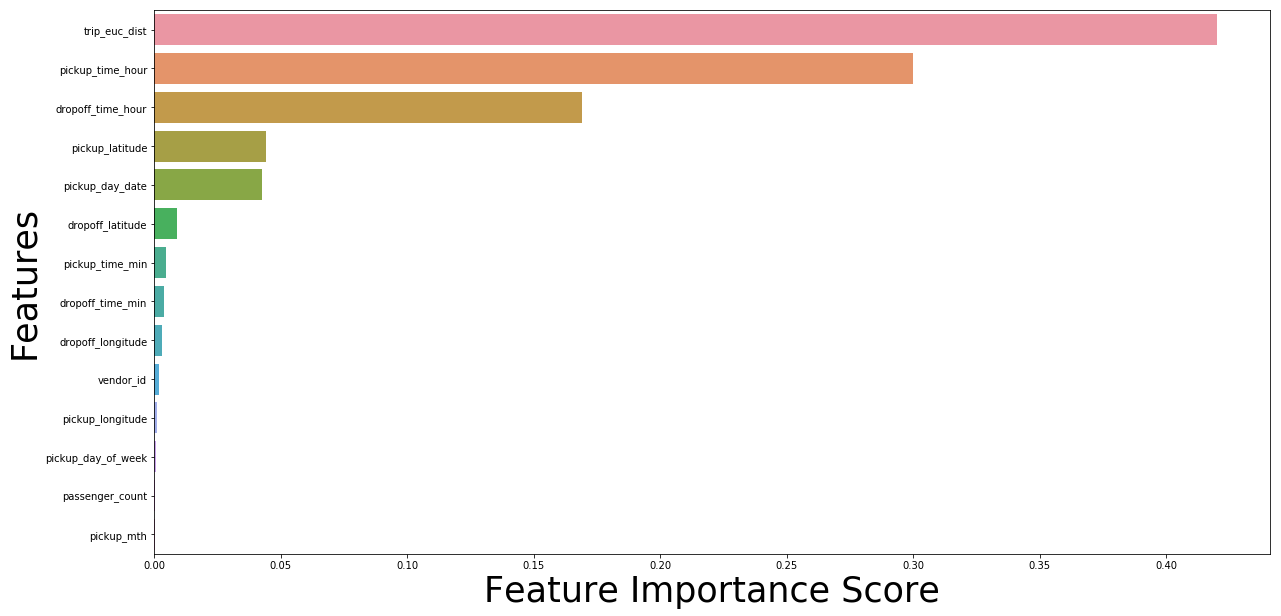

In [43]:
feat_impt = pd.DataFrame(columns=['feature_name', 'importance'])
feat_impt['feature_name'] = list(X.columns)
feat_impt['importance'] = gbdt_reg.feature_importances_
feat_impt.sort_values(by=['importance'], inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(20,10))

ax = sns.barplot(
    x='importance',
    y='feature_name',
    data=feat_impt,
)

ax.set_xlabel("Feature Importance Score", fontsize=35)
ax.set_ylabel("Features", fontsize=35)

We can see that out of all the features that we have, the (relatively) most importance feature that we have, was the engineered Euclidean distance that we obtained based on the latitude / longitudes of the original feature set.

## This time we'll try with just the Euclidean distance, pickup hour, and dropoff hour as features

In [46]:
X_two = X.drop(columns=['dropoff_latitude', 'pickup_time_min', 'dropoff_time_min', 'dropoff_longitude', 'vendor_id', 'pickup_longitude', 'pickup_day_of_week', 'passenger_count', 'pickup_mth'], axis=1)

## Setting up a new GBDT model

In [45]:
gbdt_reg_two = GradientBoostingRegressor()

## Split the data into a train and test data set

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_two, y, test_size=0.2, random_state=111)

## Train the model with only these selected features

In [49]:
# We'll additionally track the elapsed time taken to train the model
start = time.time()

gbdt_reg_two.fit(X_train, y_train)

end = time.time()

print("The time taken to train the Gradient Boosting Decision Tree regression model is " + "{:.2f}".format(end - start) + " seconds.")

The time taken to train the Gradient Boosting Decision Tree regression model is 130.38 seconds.


## Predicting the test data set

In [50]:
predicted_results = gbdt_reg_two.predict(X_test)

## Comparing the predicted values against the actual

In [51]:
compare_df = pd.DataFrame(columns=['actual', 'predicted'])
compare_df['actual'] = y_test
compare_df['predicted'] = predicted_results

In [52]:
compare_df.head()

,actual,predicted
714698,281,678.256470
1369888,590,730.298958
355495,535,561.366207
1383718,522,648.275750
951815,965,1690.979456


## Check out the performance of the default GBDT model by predicting the test data set

In [53]:
mean_squared_error(y_test, gbdt_reg_two.predict(X_test))

51302788.239182286

Up till this point, we have created 2 models, with its main differences being the number of features that we have used to train the 2 models. The first model was a default Gradient Boosted Decision Tree, using all the features that we engineered, and some of the original features that were provided in the data set.

In the second model, we again used a default GDBT model, but with a reduced subset of features, based on the impor